In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import gzip, glob, os, csv
import seaborn as sns

from cdt.metrics import SID, SHD
import scipy.linalg as slin
import scipy.optimize as sopt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score
import copy


No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [3]:
def L1(target, pred):
    return np.sum(np.abs(target - pred))

def binarize(X):
    return (X != 0) * 1

def get_precision(w_true, w):
    w_true_bin = binarize(w_true)
    w_bin = binarize(w)
    
    fp = (w_bin * (w_true_bin == 0)).sum()
    tp = (w_bin * w_true_bin).sum()

    return tp / (fp + tp)

def get_recall(w_true, w):
    w_true_bin = binarize(w_true)
    w_bin = binarize(w)
    
    fp = (w_bin * (w_true_bin == 0)).sum()
    fn = ((w_bin == 0) * w_true_bin).sum()
    tp = (w_bin * w_true_bin).sum()
    
    return tp / (tp + fn)

In [4]:
def get_fdr(w_true, w):
    w_true_bin = binarize(w_true)
    w_bin = binarize(w)
    
    fp = (w_bin * (w_true_bin == 0)).sum()
    tp = (w_bin * w_true_bin).sum()
    return fp / (fp + tp)

def get_inferred_fp_edge_weights(w_true, w):
    w_true_bin = binarize(w_true)
    w_bin = binarize(w)
    
    fp_mat = (w_bin * (w_true_bin == 0)).astype(bool)
    return w[fp_mat]
    
def get_true_fn_edge_weights(w_true, w):
    w_true_bin = binarize(w_true)
    w_bin = binarize(w)
    
    fn_mat = ((w_bin == 0) * w_true_bin).astype(bool)
    return w_true[fn_mat]

In [5]:
METHODS = [
    'dotears', 
    'notears', 
    'sortnregress', 
    'golem-ev', 
    'golem-nv', 
    'direct-lingam', 
    'gies', 
    'igsp', 
    'ut-igsp',
    'dcdi-g'
]

DAG_MODELS = ['erdos_renyi', 'scale_free']



In [6]:
RUN_NAMES = [
    'p20_high_density_weak_effects', # 0.3-0.5 edges, d0.5, p6
    'p20_high_density_strong_effects',
    'p20_low_density_weak_effects',
    'p20_low_density_strong_effects'
]


all_runs = [(base_name,
             '/u/home/a/asxue/project-hjp/dotears/data/{}/out/'.format(base_name),
             '/u/home/a/asxue/project-hjp/dotears/data/{}/dags/'.format(base_name),
             '/u/home/a/asxue/project-hjp/dotears/data/{}/data/'.format(base_name)
            ) for base_name in RUN_NAMES]

w_threshold_dict = {
    'p20_low_density_weak_effects' : 0.2,
    'p20_high_density_weak_effects': 0.2,
    'p20_low_density_strong_effects' : 0.2,
    'p20_high_density_strong_effects': 0.2,
}

experiments = [
#     'standard',
    'fixed_intervention',
    'a_perturbed'
]

In [7]:
df = pd.DataFrame(columns=['method', 'L1 dist', 'SHD', 'p', 'fdr', 'DAG type', 'sim type', 'sim id', 'experiment', 'precision', 'recall'])
dags = []
param_grids = []

for base_name, out_dirs, true_dirs, data_dirs in all_runs:
    for experiment in experiments:
        out_dir = os.path.join(out_dirs, experiment)
        true_dir = os.path.join(true_dirs, experiment)
        data_dir = os.path.join(data_dirs, experiment)

        for method in METHODS:
            for dag_model in DAG_MODELS:
                for dag_num, dag in enumerate(glob.glob(os.path.join(true_dir, dag_model, '*'))):
                    w_true = np.loadtxt(dag)
                    path = os.path.join(out_dir, method, dag)

                    sim = os.path.basename(dag).split('.')[0]
                    sim_id = sim.split('_')[1]
                    
#                     if int(sim_id) > 4:
#                         continue

                    path = os.path.join(out_dir, dag_model, method, sim + '.npy')
                    W = np.load(path)

                    dags.append([w_true, W, method, dag_model])

                    if method in METHODS:
                        W[np.abs(W) < w_threshold_dict[base_name]] = 0
                        pass

                    l1_dist = L1(w_true, W)
                    shd = SHD(binarize(w_true), binarize(W), double_for_anticausal=False)
                    
                    prec = get_precision(w_true, W)
                    recall = get_recall(w_true, W)

#                         for w_threshold in np.arange(0.1, 1.05, .05):
#                             W_thresholded = (np.abs(W) >= w_threshold) * W

#                             fdr = get_fdr(w_true, W_thresholded)
#                             fdr_df.loc[len(fdr_df.index), :] = [fdr, np.round(w_threshold, 2), method, data_type]

                    fdr = get_fdr(w_true, W)
                    df.loc[len(df.index), :] = [method, 
                                                l1_dist,
                                                shd,
                                                W.shape[0],
                                                fdr,
                                                dag_model,
                                                base_name,
                                                int(sim_id),
                                                experiment,
                                                prec,
                                                recall
                                               ]      
                

In [8]:
mpl.style.use('ggplot')
# plt.style.use(['science'])

plt.rcParams['lines.linewidth']= 3
plt.rcParams['axes.facecolor']= 'white'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.labelcolor']= 'black'

plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color']= 'black'

plt.rcParams['xtick.labelsize'] = 28
plt.rcParams['ytick.labelsize'] = 28
plt.rcParams['axes.labelsize'] = 32
plt.rcParams['axes.titlesize'] = 32


plt.rcParams['xtick.major.size'] = 8
plt.rcParams['ytick.major.size'] = 8


plt.rcParams['text.usetex'] = False

plt.rcParams['axes.labelpad'] = 8
plt.rcParams['axes.linewidth'] = 2

mpl.rc('font', family='sans-serif') 
mpl.rc('font', serif='Helvetica') 

# colormap = ['#77AADD', '#EE8866', '#EEDD88', '#FFAABB', '#99DDFF', '#44BB99', '#BBCC33', '#AAAA00', '#DDDDDD'] #light
colormap = [
    '#59C7EB', 
    '#E0607E',  
    '#0A9086', 
    '#FEA090', 
    '#3E5496', 
    '#EFDC60', 
    '#8E2043', 
    '#9AA0A7', 
    '#077187', 
    'orange'
] #unikn pal pref

HUE_METHODS = [
    'dotears', 
    'gies', 
    'notears', 
    'sortnregress', 
    'direct-lingam', 
    'igsp', 
    'golem-nv', 
    'golem-ev', 
    'ut-igsp', 
    'dcdi-g'
]
# HUE_METHODS = ['dotears', 'sortnregress', 'notears', 'gies', 'golem-nv', 'igsp', 'direct-lingam', 'golem-ev']
CV_NAME_DICT = {
    'dotears': 'dotears*',
    'gies': 'GIES',
    'notears': 'NO TEARS*',
    'sortnregress': 'sortnregress*',
    'golem-nv': 'GOLEM-NV*',
    'igsp': 'IGSP',
    'direct-lingam': 'DirectLiNGAM',
    'golem-ev': 'GOLEM-EV*',
    'ut-igsp': 'UT-IGSP',
    'dcdi-g': 'DCDI-G*'
}

color_dict = {
    x[0]: x[1] for x in zip(HUE_METHODS, colormap)
}


Text(0, 0.5, 'Recall')

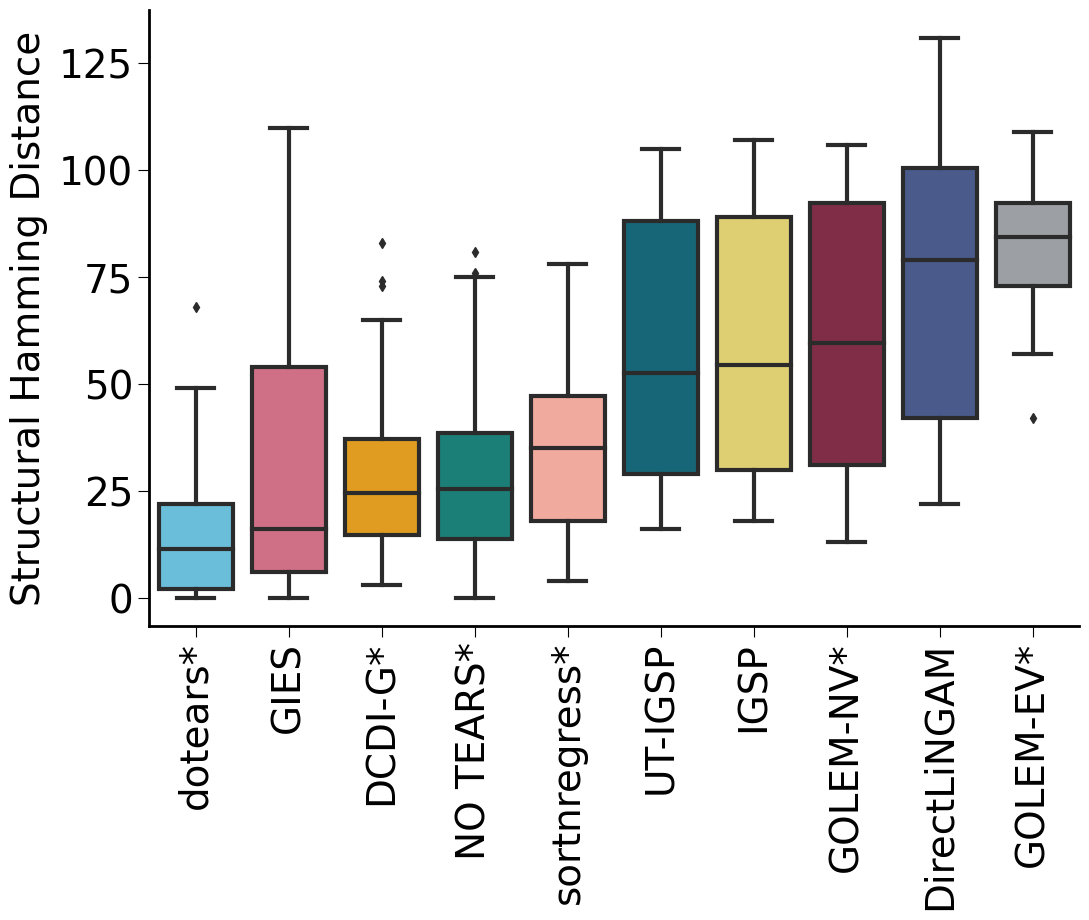

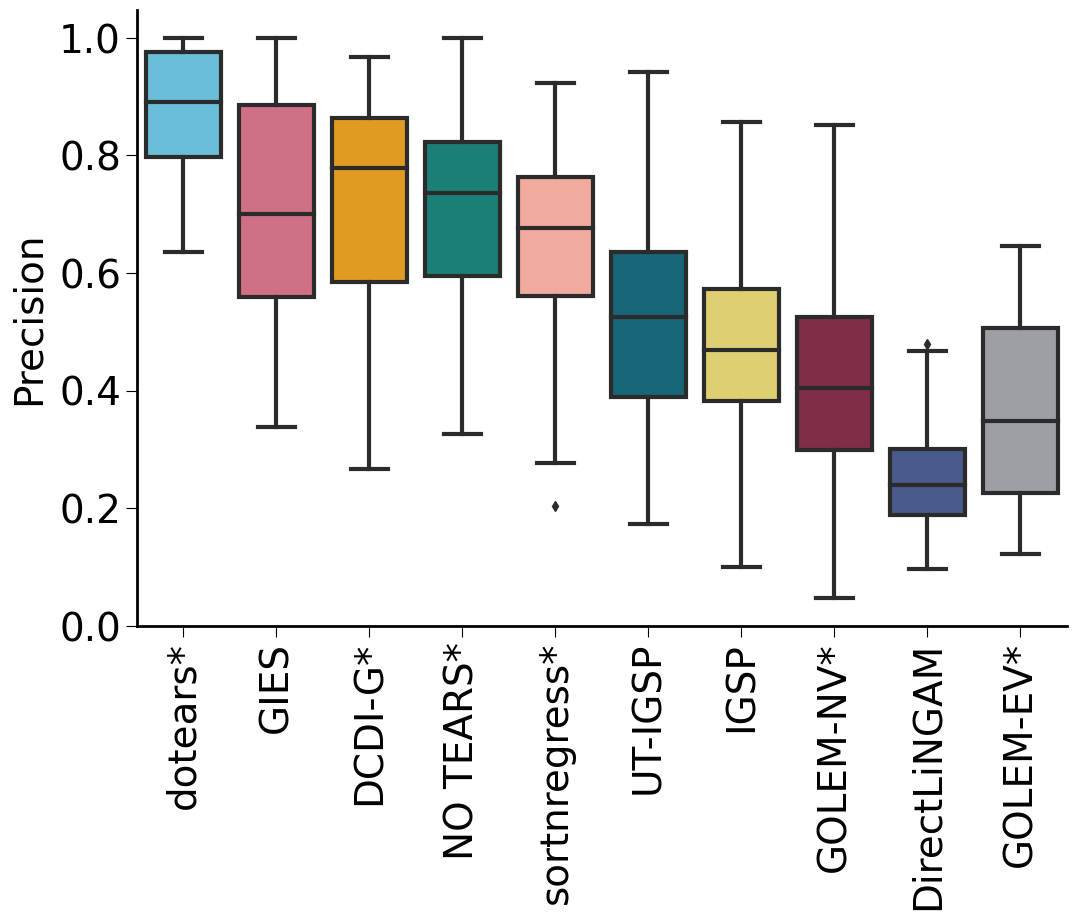

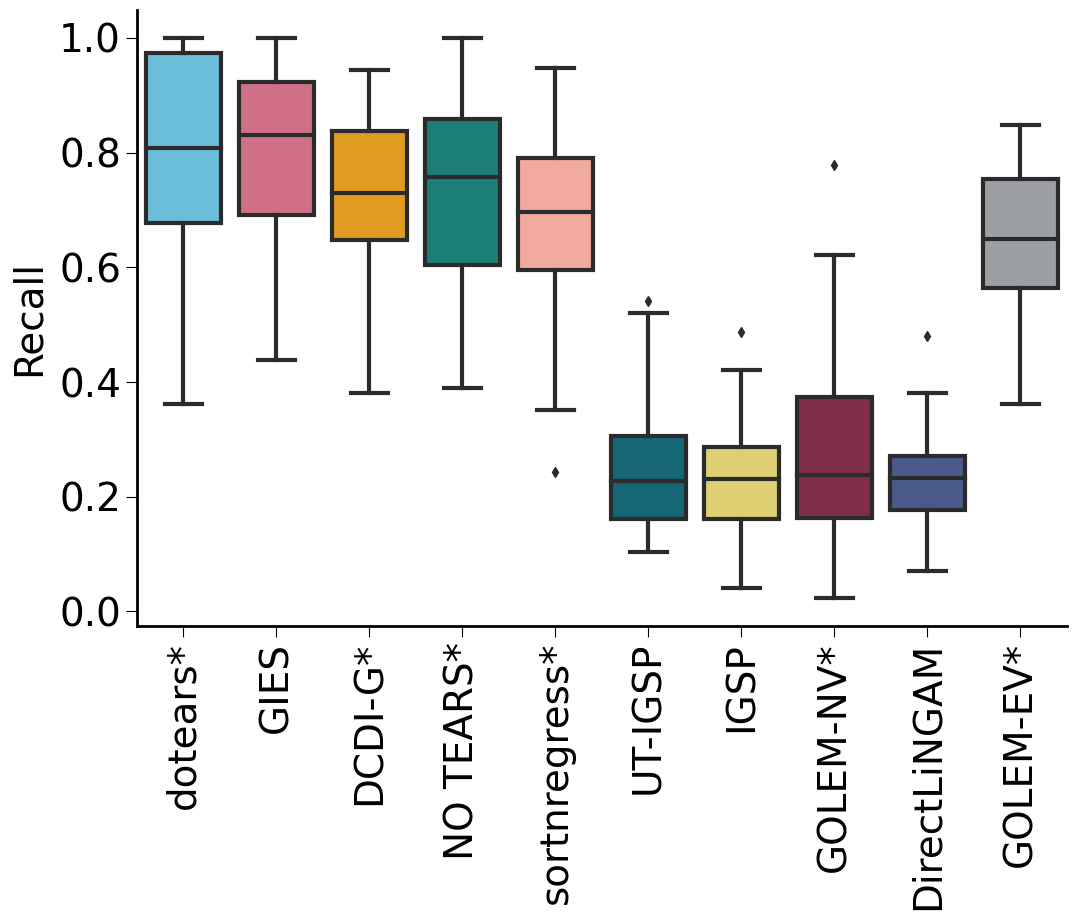

In [9]:
plt.figure(figsize=(12, 8))

ORDERED_METHODS = sorted(HUE_METHODS, key=lambda x: df.loc[(df['method'] == x) & (df['experiment'] == 'a_perturbed'),
                                                           'SHD'].median())
DISPLAY_METHODS = [CV_NAME_DICT[x] for x in ORDERED_METHODS]

sns.boxplot(data=df[df['experiment'] == 'a_perturbed'], 
            x='method', 
            y='SHD',
            order=ORDERED_METHODS,
            palette=color_dict
           )

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels(DISPLAY_METHODS, rotation=90)
plt.xticks(rotation=90)
plt.xlabel(None)
plt.ylabel('Structural Hamming Distance', fontsize=28)

plt.figure(figsize=(12, 8))

sns.boxplot(data=df[df['experiment'] == 'a_perturbed'], 
            x='method', 
            y='precision',
            order=ORDERED_METHODS,
            palette=color_dict
           )

ax = plt.gca()
ax.set_xticklabels(DISPLAY_METHODS, rotation=90)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(rotation=90)
plt.xlabel(None)
plt.ylabel('Precision', fontsize=28)

plt.figure(figsize=(12, 8))

sns.boxplot(data=df[df['experiment'] == 'a_perturbed'], 
            x='method', 
            y='recall',
            order=ORDERED_METHODS,
            palette=color_dict
           )

ax = plt.gca()
ax.set_xticklabels(DISPLAY_METHODS, rotation=90)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(rotation=90)
plt.xlabel(None)
plt.ylabel('Recall', fontsize=28)



Text(0, 0.5, 'Recall')

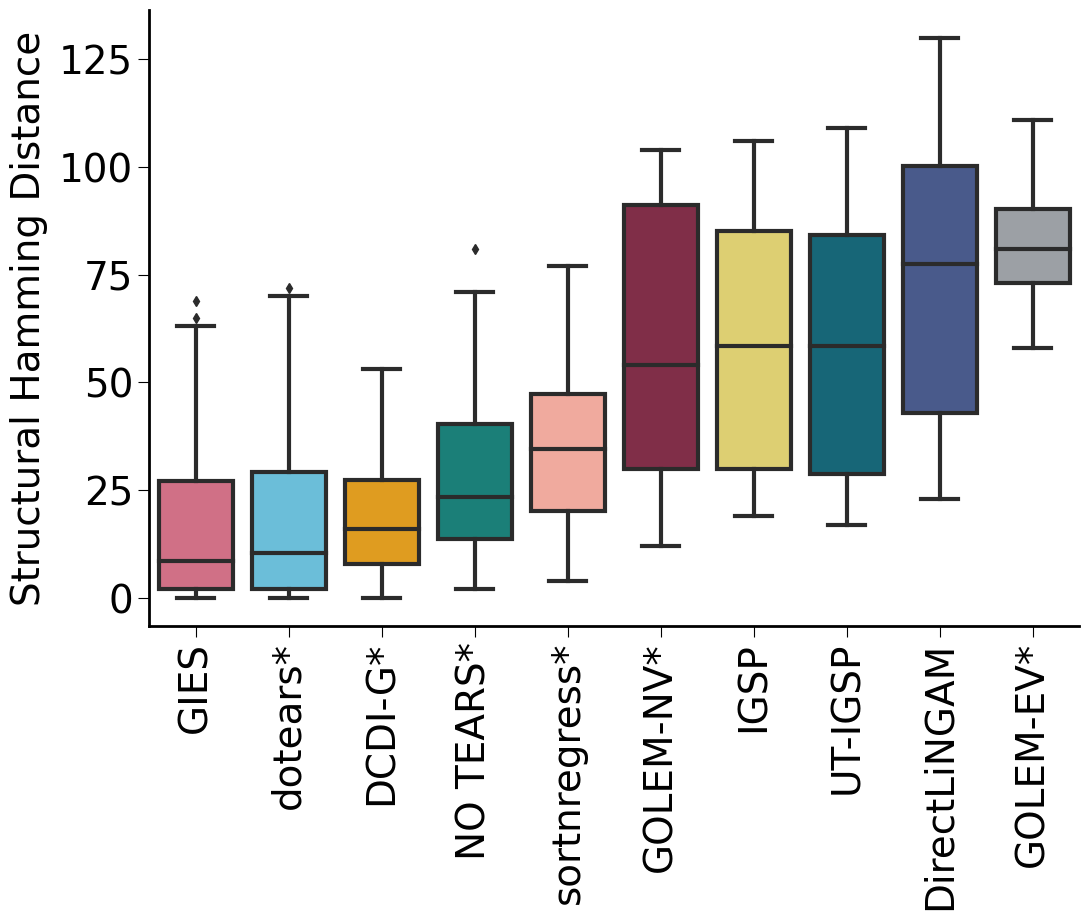

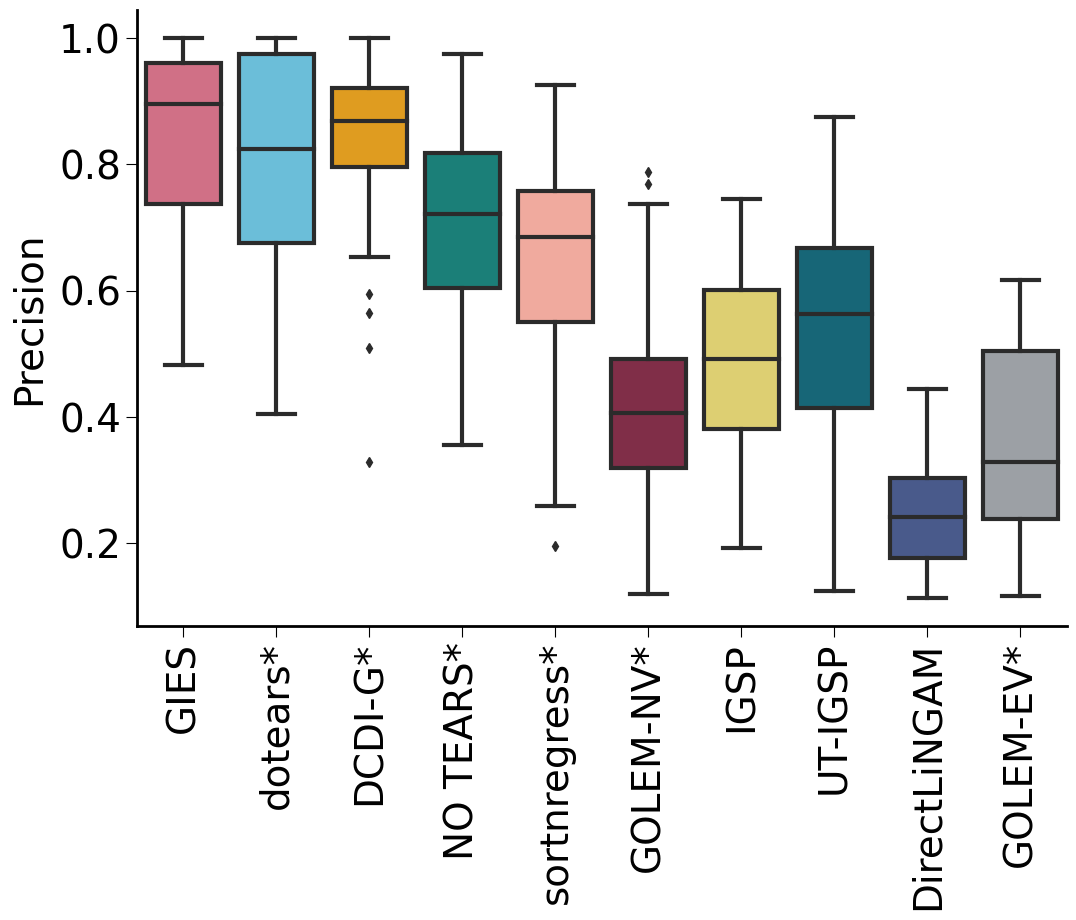

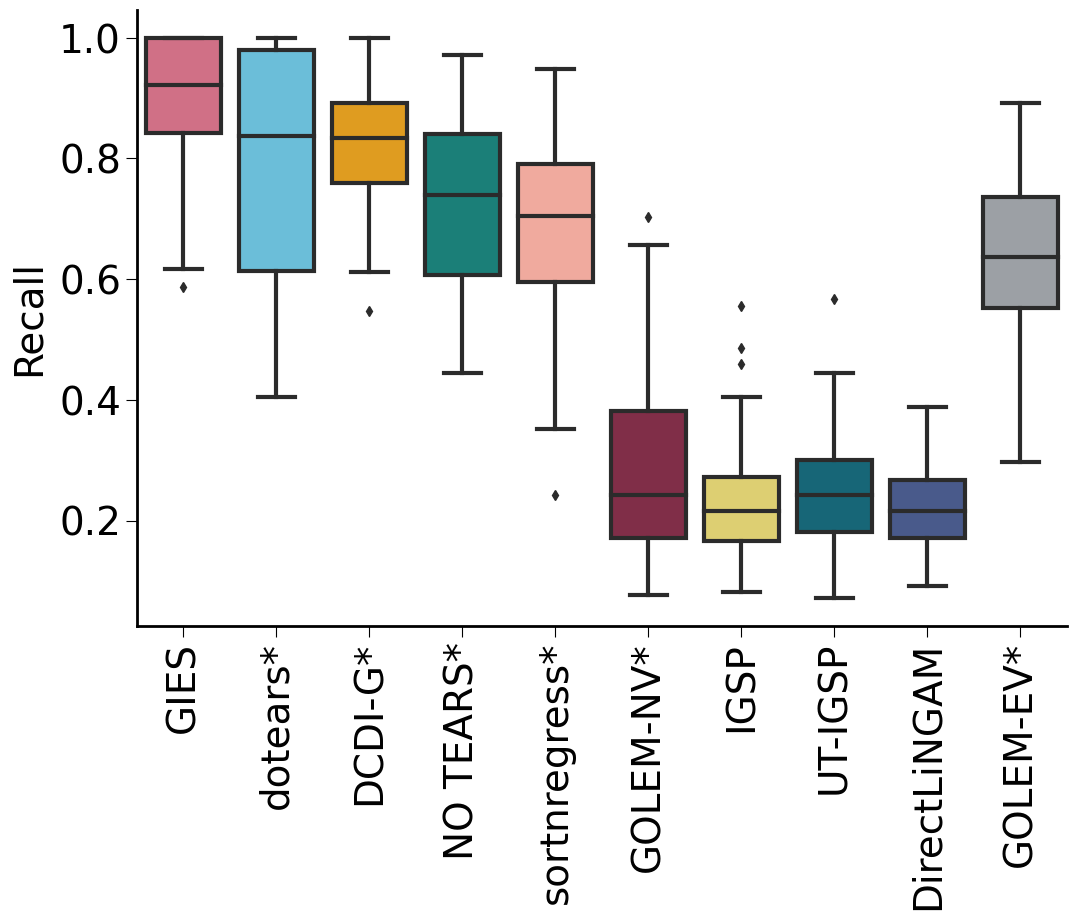

In [10]:
plt.figure(figsize=(12, 8))

ORDERED_METHODS = sorted(HUE_METHODS, key=lambda x: df.loc[(df['method'] == x) & (df['experiment'] == 'fixed_intervention'),
                                                           'SHD'].median())
DISPLAY_METHODS = [CV_NAME_DICT[x] for x in ORDERED_METHODS]

sns.boxplot(data=df[df['experiment'] == 'fixed_intervention'], 
            x='method', 
            y='SHD',
           order=ORDERED_METHODS,
           palette=color_dict)

ax = plt.gca()
ax.set_xticklabels(DISPLAY_METHODS, rotation=90)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(rotation=90)
plt.xlabel(None)

plt.ylabel('Structural Hamming Distance', fontsize=28)

plt.figure(figsize=(12, 8))

sns.boxplot(data=df[df['experiment'] == 'fixed_intervention'], 
            x='method', 
            y='precision',
            order=ORDERED_METHODS,
            palette=color_dict
           )

ax = plt.gca()
ax.set_xticklabels(DISPLAY_METHODS, rotation=90)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(rotation=90)
plt.xlabel(None)
plt.ylabel('Precision', fontsize=28)



plt.figure(figsize=(12, 8))

sns.boxplot(data=df[df['experiment'] == 'fixed_intervention'], 
            x='method', 
            y='recall',
            order=ORDERED_METHODS,
            palette=color_dict
           )

ax = plt.gca()
ax.set_xticklabels(DISPLAY_METHODS, rotation=90)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(rotation=90)
plt.xlabel(None)
plt.ylabel('Recall', fontsize=28)



['dotears', 'dcdi-g', 'gies', 'notears', 'sortnregress', 'ut-igsp', 'igsp', 'golem-nv', 'direct-lingam', 'golem-ev']


Using the boxplot function without specifying `hue_order` is likely to produce an incorrect plot.
The figure layout has changed to tight


experiment = a_perturbed | sim type = p20_low_density_strong_effects
experiment = a_perturbed | sim type = p20_low_density_weak_effects
experiment = a_perturbed | sim type = p20_high_density_strong_effects
experiment = a_perturbed | sim type = p20_high_density_weak_effects


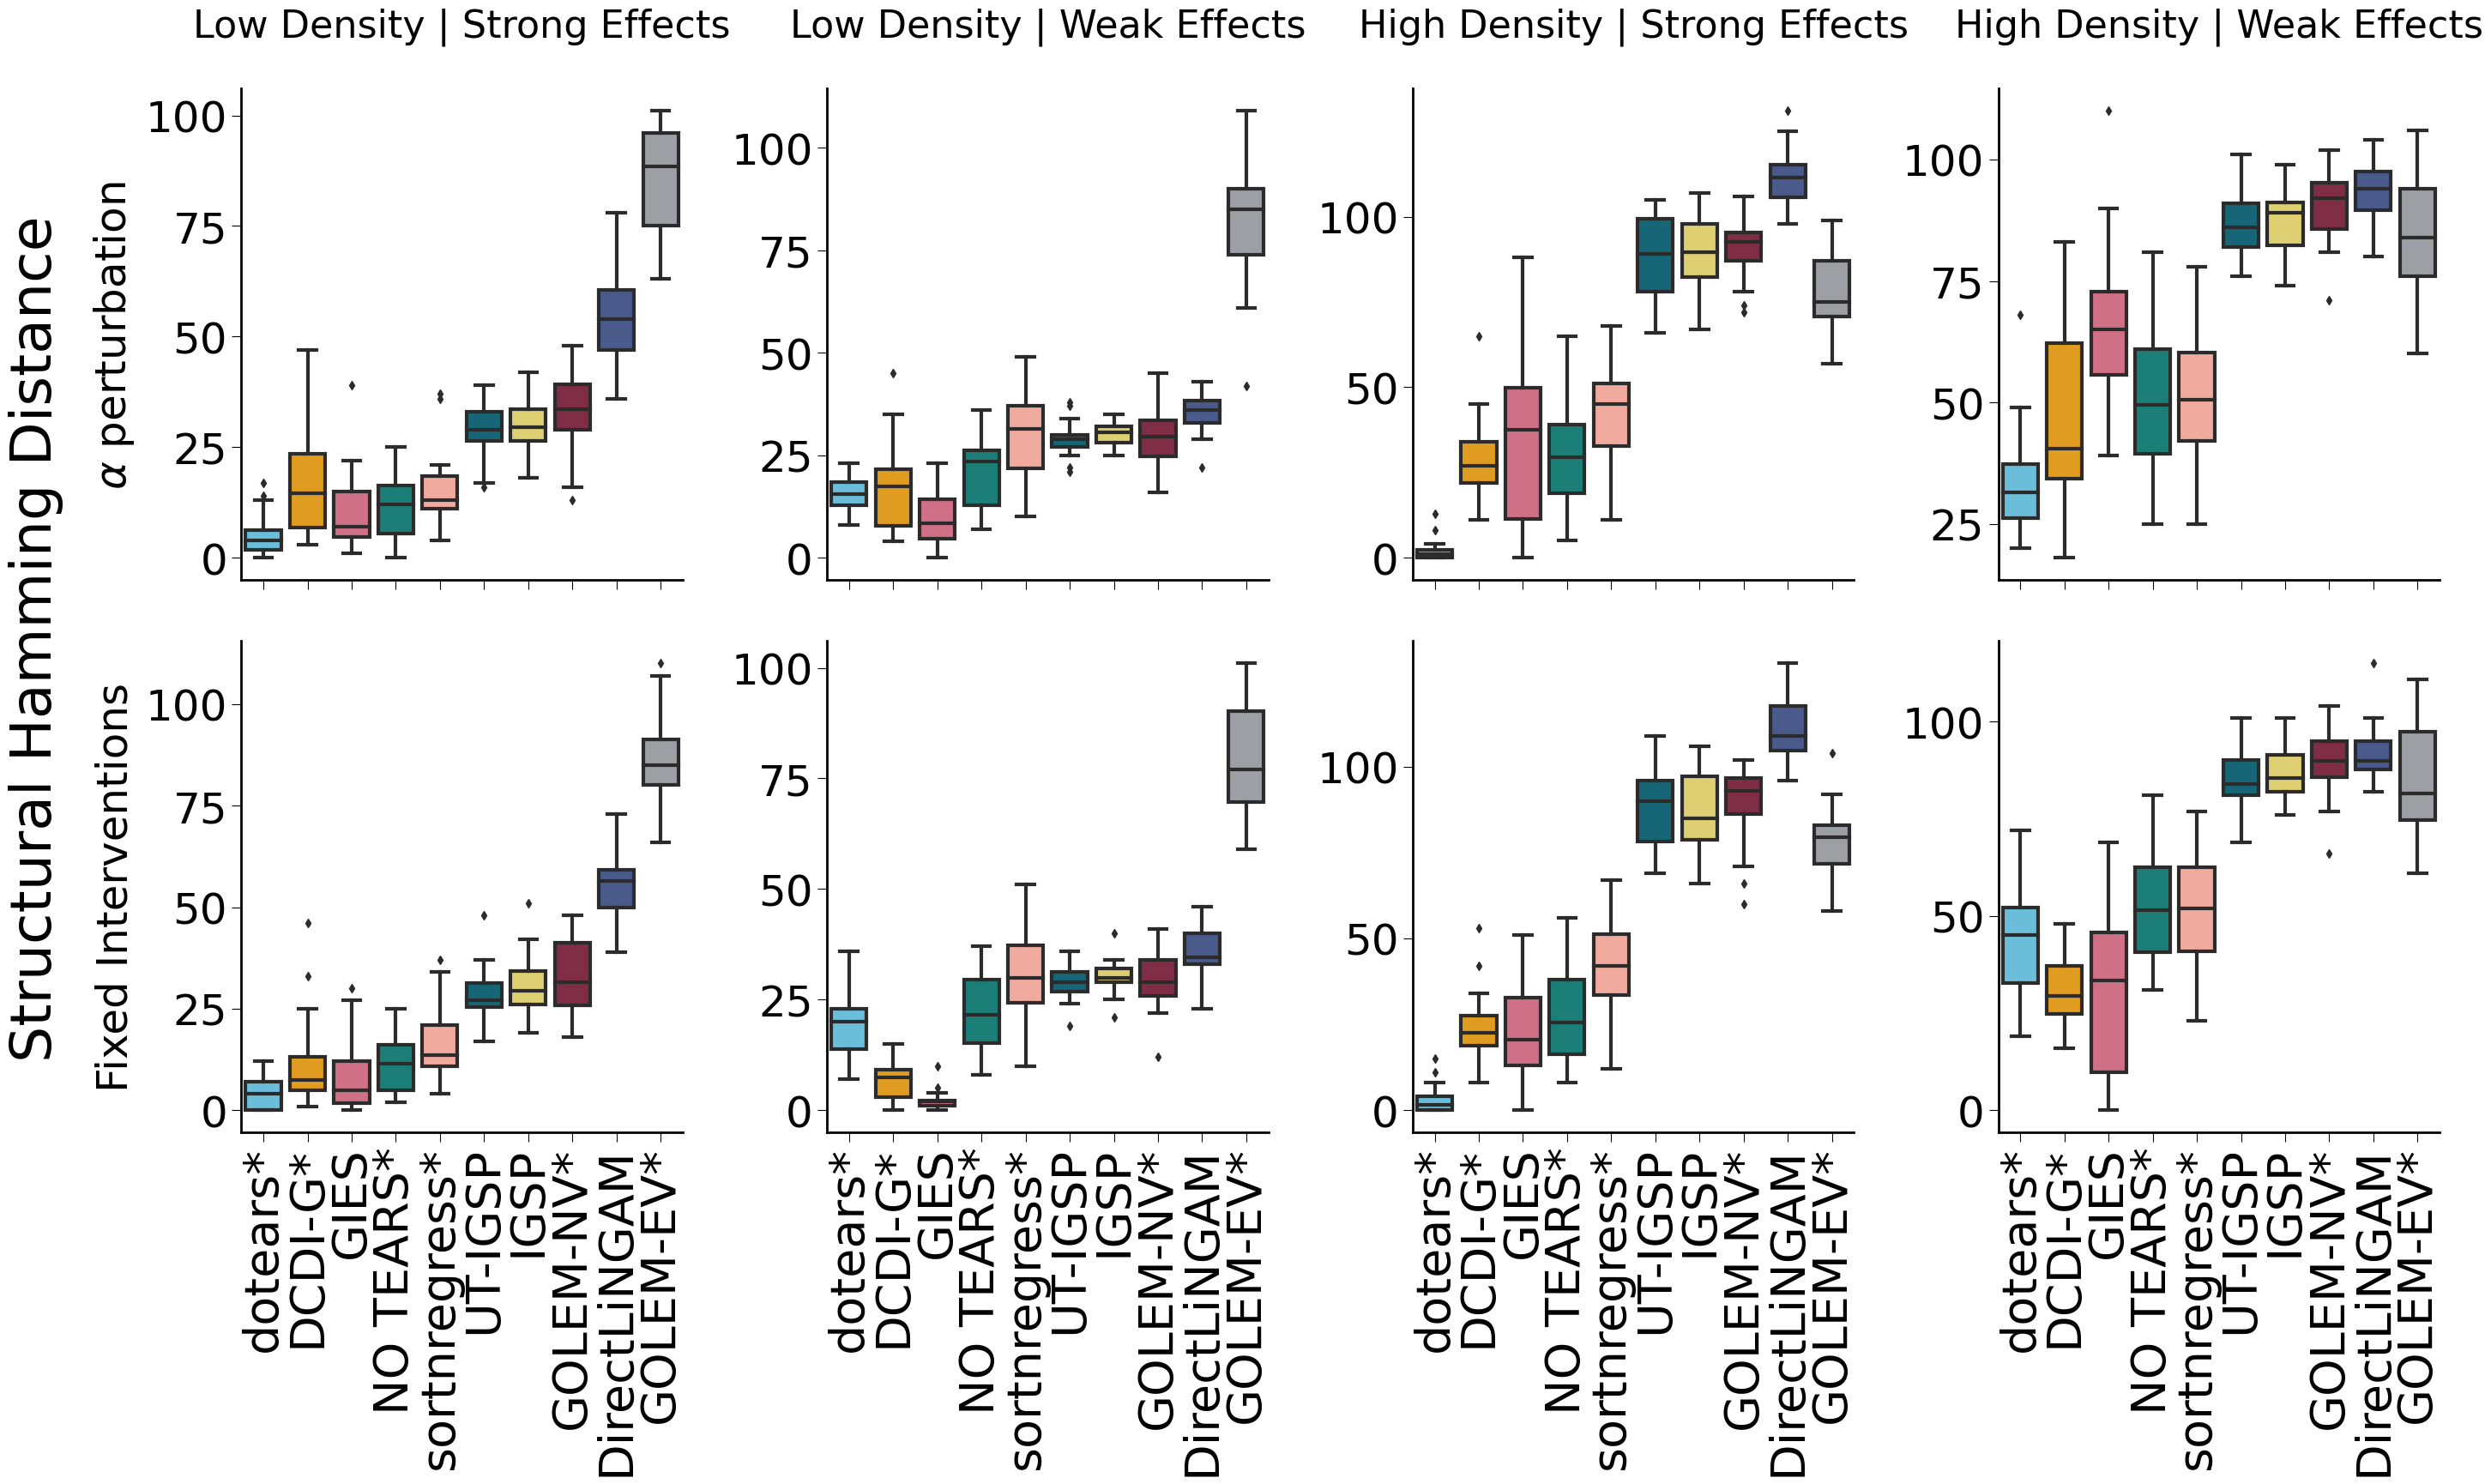

In [11]:

# plot_df = df[df['experiment'] == 'a_perturbed']

title_name_map = {
    'p20_high_density_strong_effects': 'High Density | Strong Effects',
    'p20_high_density_weak_effects': 'High Density | Weak Effects',
    'p20_low_density_strong_effects': 'Low Density | Strong Effects',
    'p20_low_density_weak_effects': 'Low Density | Weak Effects'
}


# dag_name_map = {
#     'erdos_renyi': r'Erd$o\H$s-R$\'{e}$nyi',
#     'scale_free': 'Scale-Free'
# }

COL_ORDER = [
    'p20_low_density_strong_effects',
    'p20_low_density_weak_effects',
    'p20_high_density_strong_effects',
    'p20_high_density_weak_effects',
]
# plt.figure(figsize=(12, 8))
ORDERED_METHODS = sorted(HUE_METHODS, key=lambda x: df.loc[df['method'] == x, 'SHD'].mean())
DISPLAY_METHODS = [CV_NAME_DICT[x] for x in ORDERED_METHODS]

print(ORDERED_METHODS)
g = sns.FacetGrid(df, row='experiment', col='sim type',
                  height=7,
                  aspect=1,
                  sharey=False,
                  col_order=COL_ORDER,
                  row_order=['a_perturbed', 'fixed_intervention'])

g.map(sns.boxplot, 'method', 'SHD',
      'method',
      order=ORDERED_METHODS,
      dodge=False,
      palette=color_dict)

fig = plt.gcf()
# print(fig.subfigures())
for i, row in enumerate(g.axes):
    for j, ax in enumerate(row):
        something = ax.get_xticklabels()
        ax.set_xticklabels(DISPLAY_METHODS, rotation=90)
#         plt.xticks(rotation=90)
        title = ax.get_title()
        dag_type = title.split(' | ')[0].split(' = ')[-1]
        
        if i != 0:
            ax.set_title(None)
            
        if j == 0:
            if i == 0:
                ax.set_ylabel(r'$\alpha$ perturbation', fontsize=36)
            if i == 1:
                ax.set_ylabel('Fixed Interventions', fontsize=36)
            
        ax.set_xlabel(None)
        ax.tick_params(axis='x', which='major', labelsize=40)
        ax.tick_params(axis='y', which='major', labelsize=36)
        
        ax.locator_params(axis='y', nbins=5)
        
    if i == 0: 
        for ax in row:
            title = ax.get_title()
            print(title)
            sim_type = title.split('|')[-1].split(' = ')[-1]
            ax.set_title(title_name_map[sim_type] + '\n', fontsize=32)
            
g.fig.supylabel('Structural Hamming Distance', fontsize=48, x=-0.04)

plt.savefig('/u/home/a/asxue/project-hjp/dotears/RECOMB/other_sims.png',
            dpi=1000,
            bbox_inches='tight')

['dotears', 'dcdi-g', 'gies', 'notears', 'sortnregress', 'ut-igsp', 'igsp', 'golem-nv', 'direct-lingam', 'golem-ev']


Using the boxplot function without specifying `hue_order` is likely to produce an incorrect plot.


experiment = a_perturbed | sim type = p20_low_density_strong_effects
experiment = a_perturbed | sim type = p20_low_density_weak_effects
experiment = a_perturbed | sim type = p20_high_density_strong_effects
experiment = a_perturbed | sim type = p20_high_density_weak_effects


The figure layout has changed to tight


Text(-0.04, 0.5, 'Precision')

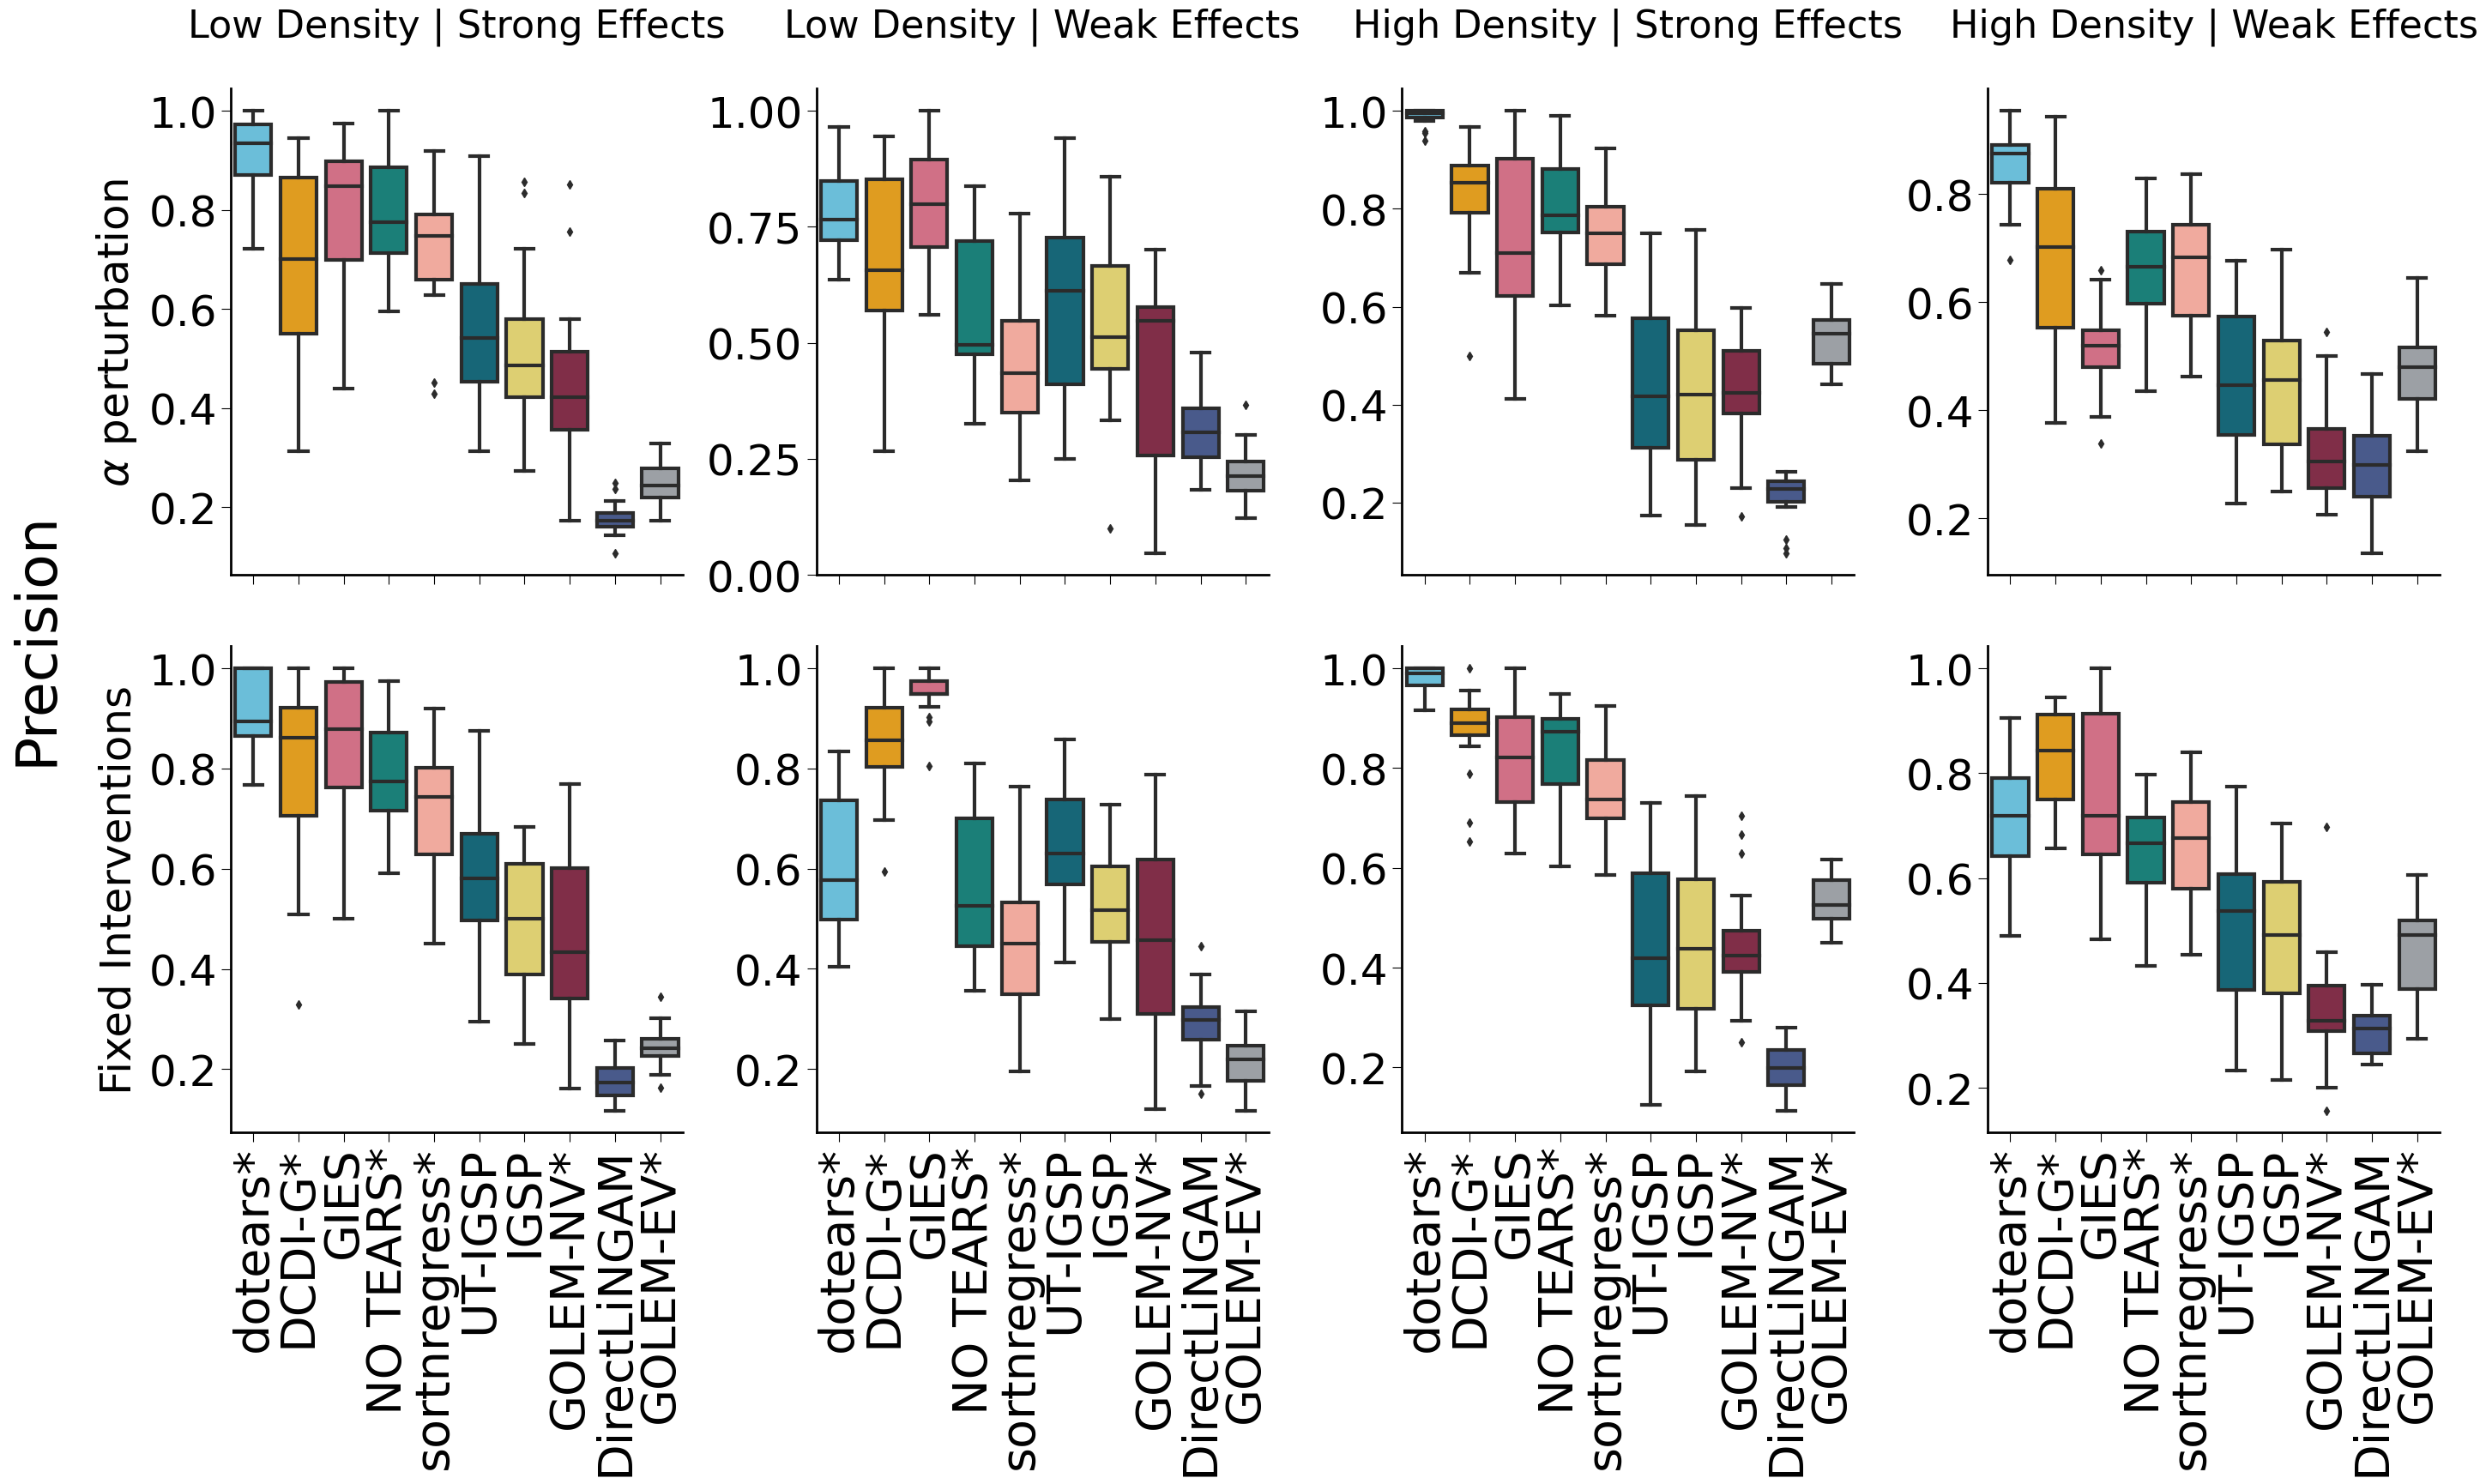

In [12]:

# plot_df = df[df['experiment'] == 'a_perturbed']

title_name_map = {
    'p20_high_density_strong_effects': 'High Density | Strong Effects',
    'p20_high_density_weak_effects': 'High Density | Weak Effects',
    'p20_low_density_strong_effects': 'Low Density | Strong Effects',
    'p20_low_density_weak_effects': 'Low Density | Weak Effects'
}


# dag_name_map = {
#     'erdos_renyi': r'Erd$o\H$s-R$\'{e}$nyi',
#     'scale_free': 'Scale-Free'
# }

COL_ORDER = [
    'p20_low_density_strong_effects',
    'p20_low_density_weak_effects',
    'p20_high_density_strong_effects',
    'p20_high_density_weak_effects',
]
# plt.figure(figsize=(12, 8))
ORDERED_METHODS = sorted(HUE_METHODS, key=lambda x: df.loc[df['method'] == x, 'SHD'].mean())
DISPLAY_METHODS = [CV_NAME_DICT[x] for x in ORDERED_METHODS]

print(ORDERED_METHODS)
g = sns.FacetGrid(df, row='experiment', col='sim type',
                  height=7,
                  aspect=1,
                  sharey=False,
                  col_order=COL_ORDER,
                  row_order=['a_perturbed', 'fixed_intervention'])

g.map(sns.boxplot, 'method', 'precision',
      'method',
      order=ORDERED_METHODS,
      dodge=False,
      palette=color_dict)

fig = plt.gcf()
# print(fig.subfigures())
for i, row in enumerate(g.axes):
    for j, ax in enumerate(row):
        something = ax.get_xticklabels()
        ax.set_xticklabels(DISPLAY_METHODS, rotation=90)
#         plt.xticks(rotation=90)
        title = ax.get_title()
        dag_type = title.split(' | ')[0].split(' = ')[-1]
        
        if i != 0:
            ax.set_title(None)
            
        if j == 0:
            if i == 0:
                ax.set_ylabel(r'$\alpha$ perturbation', fontsize=36)
            if i == 1:
                ax.set_ylabel('Fixed Interventions', fontsize=36)
            
        ax.set_xlabel(None)
        ax.tick_params(axis='x', which='major', labelsize=40)
        ax.tick_params(axis='y', which='major', labelsize=36)
        
        ax.locator_params(axis='y', nbins=5)
        
    if i == 0: 
        for ax in row:
            title = ax.get_title()
            print(title)
            sim_type = title.split('|')[-1].split(' = ')[-1]
            ax.set_title(title_name_map[sim_type] + '\n', fontsize=32)
            
g.fig.supylabel('Precision', fontsize=48, x=-0.04)


['dotears', 'dcdi-g', 'gies', 'notears', 'sortnregress', 'ut-igsp', 'igsp', 'golem-nv', 'direct-lingam', 'golem-ev']


Using the boxplot function without specifying `hue_order` is likely to produce an incorrect plot.


experiment = a_perturbed | sim type = p20_low_density_strong_effects
experiment = a_perturbed | sim type = p20_low_density_weak_effects
experiment = a_perturbed | sim type = p20_high_density_strong_effects
experiment = a_perturbed | sim type = p20_high_density_weak_effects


The figure layout has changed to tight


Text(-0.04, 0.5, 'Recall')

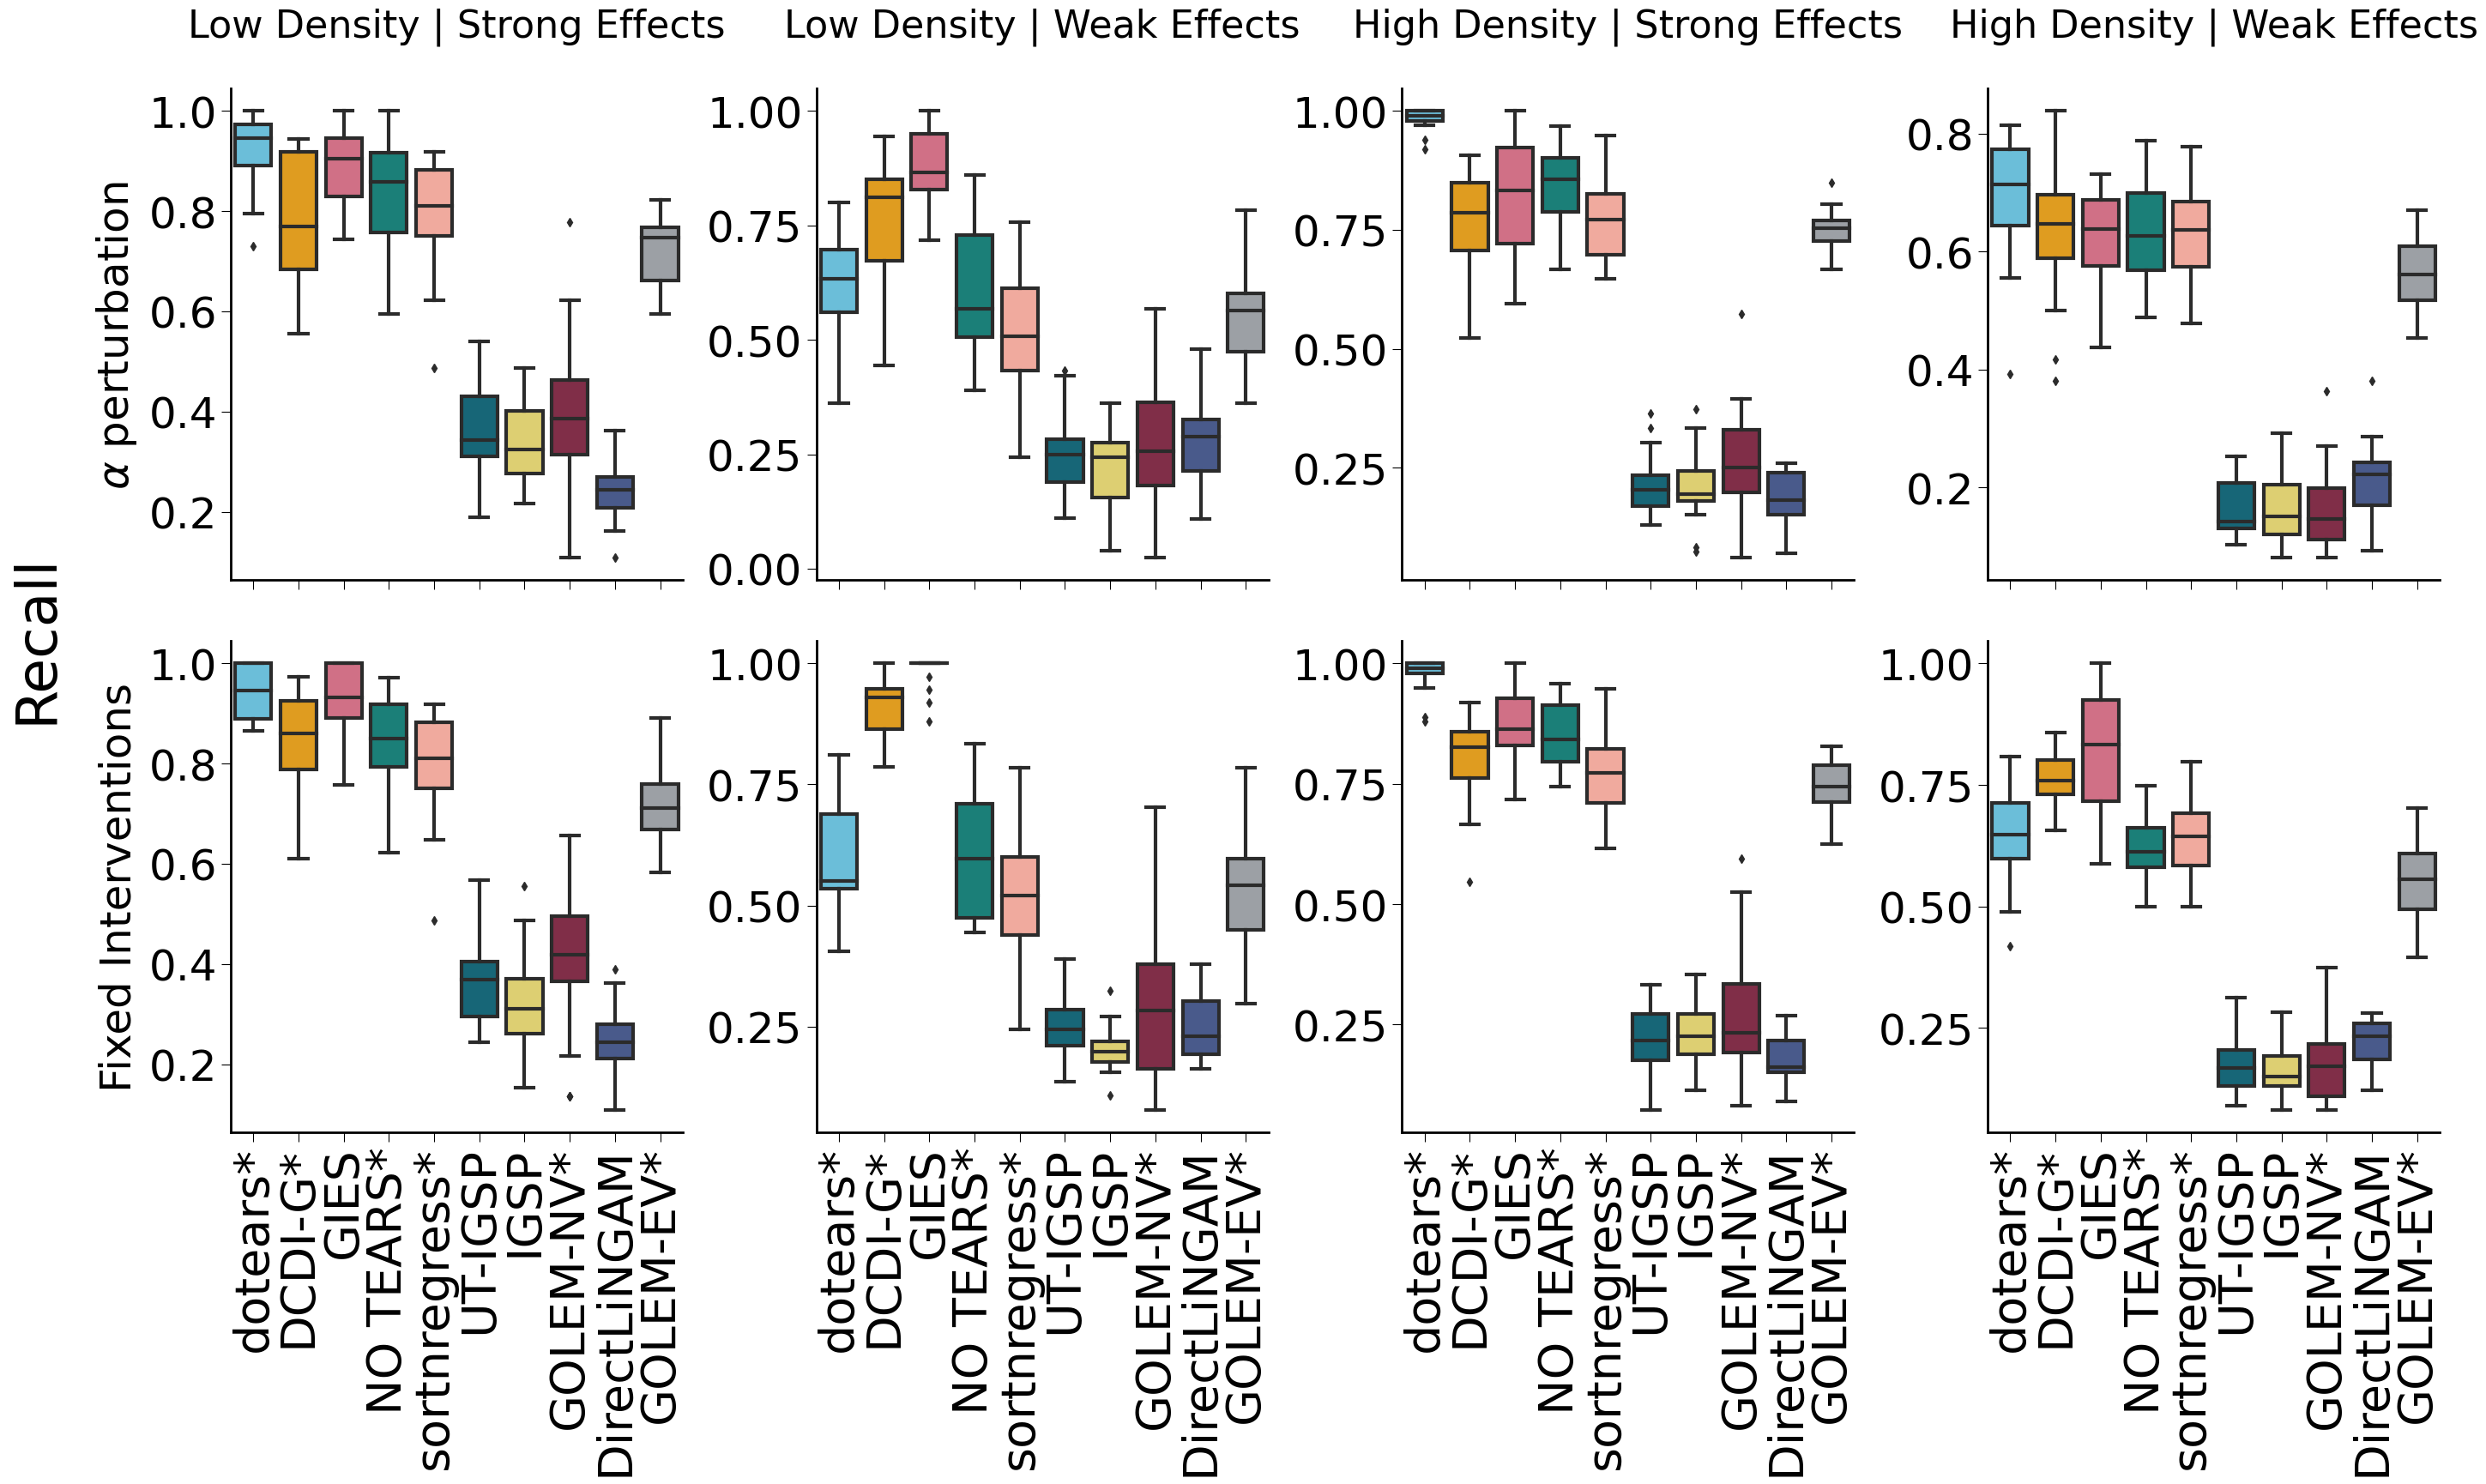

In [13]:

# plot_df = df[df['experiment'] == 'a_perturbed']

title_name_map = {
    'p20_high_density_strong_effects': 'High Density | Strong Effects',
    'p20_high_density_weak_effects': 'High Density | Weak Effects',
    'p20_low_density_strong_effects': 'Low Density | Strong Effects',
    'p20_low_density_weak_effects': 'Low Density | Weak Effects'
}


# dag_name_map = {
#     'erdos_renyi': r'Erd$o\H$s-R$\'{e}$nyi',
#     'scale_free': 'Scale-Free'
# }

COL_ORDER = [
    'p20_low_density_strong_effects',
    'p20_low_density_weak_effects',
    'p20_high_density_strong_effects',
    'p20_high_density_weak_effects',
]
# plt.figure(figsize=(12, 8))
ORDERED_METHODS = sorted(HUE_METHODS, key=lambda x: df.loc[df['method'] == x, 'SHD'].mean())
DISPLAY_METHODS = [CV_NAME_DICT[x] for x in ORDERED_METHODS]

print(ORDERED_METHODS)
g = sns.FacetGrid(df, row='experiment', col='sim type',
                  height=7,
                  aspect=1,
                  sharey=False,
                  col_order=COL_ORDER,
                  row_order=['a_perturbed', 'fixed_intervention'])

g.map(sns.boxplot, 'method', 'recall',
      'method',
      order=ORDERED_METHODS,
      dodge=False,
      palette=color_dict)

fig = plt.gcf()
# print(fig.subfigures())
for i, row in enumerate(g.axes):
    for j, ax in enumerate(row):
        something = ax.get_xticklabels()
        ax.set_xticklabels(DISPLAY_METHODS, rotation=90)
#         plt.xticks(rotation=90)
        title = ax.get_title()
        dag_type = title.split(' | ')[0].split(' = ')[-1]
        
        if i != 0:
            ax.set_title(None)
            
        if j == 0:
            if i == 0:
                ax.set_ylabel(r'$\alpha$ perturbation', fontsize=36)
            if i == 1:
                ax.set_ylabel('Fixed Interventions', fontsize=36)
            
        ax.set_xlabel(None)
        ax.tick_params(axis='x', which='major', labelsize=40)
        ax.tick_params(axis='y', which='major', labelsize=36)
        
        ax.locator_params(axis='y', nbins=5)
        
    if i == 0: 
        for ax in row:
            title = ax.get_title()
            print(title)
            sim_type = title.split('|')[-1].split(' = ')[-1]
            ax.set_title(title_name_map[sim_type] + '\n', fontsize=32)
            
g.fig.supylabel('Recall', fontsize=48, x=-0.04)
